<center><img src="image/logo.png" alt="logo.png" border="0" width="500"/></center>
<center><b>mdapy</b>: Molecular dynamics simulation analysis with Python</center>
<center> <b>Author</b>：Yong-Chao Wu </center>
<center> <b>Supervisor</b>: Jian-Li Shao</center>
<center> <b>Date</b>: 2023/11/24</center>

# 引用

>```bibtex
@article{mdapy2023,
title = {mdapy: A flexible and efficient analysis software for molecular dynamics simulations}, 
journal = {Computer Physics Communications},
pages = {108764},
year = {2023},
issn = {0010-4655},
doi = {https://doi.org/10.1016/j.cpc.2023.108764},
url = {https://www.sciencedirect.com/science/article/pii/S0010465523001091},
author = {Yong-Chao Wu and Jian-Li Shao},
keywords = {Simulation analysis, Molecular dynamics, Polycrystal, TaiChi, Parallel computing}
}
```

# 相关链接

- Homepage: [https://github.com/mushroomfire/mdapy](https://github.com/mushroomfire/mdapy)
- Documentation: [https://mdapy.readthedocs.io](https://mdapy.readthedocs.io/)

# 什么是mdapy

**mdapy是一个高性能的分子动力学前/后处理的Python库。**

# 优点 V.S. 缺点

> **优点**

- 跨平台，安装简单，语法简单
- 支持多核CPU并行和GPU计算
- 数据存储格式为Numpy的NDARRY和Polars的DataFrame, 可以无缝衔接Python科学计算生态
- 具有非常快的文件I/O性能，良好的计算性能
- 支持正交/斜盒子体系
- 支持周期性边界

> **缺点**

- 主要面向固体材料的模拟，特别是金属/合金体系, 但设计架构上可扩展到任何全原子体系
- 适合于单一Frame的系统状态分析，不擅长一个轨迹中不同Frame间的关联分析
- 并行方式为共享内存并行，目前不支持跨节点并行
- 可视化功能还处在实验性阶段
- 支持的文件格式较少，目前直接支持LAMMPS中的DUMP和DATA格式，VASP中的POSCAR格式，通用的XYZ格式，其他格式需要手动转换

<img src="image/bench.jpg" alt="bench.jpg" border="0" width="800"/>

# 安装

> ```bash
> conda create -n mda python=3.10
> conda activate mda
> pip install mdapy -U 
> pip install mdapy[all] -U # If you want to install all optional dependencies```

# 主要功能

<img src="image/main_feature.jpg" alt="main_feature.jpg" border="0" width="800"/>

# 工作流示意图

<img src="image/workflow.png" alt="workflow.png" border="0" width="800"/>

# 新手教程

默认会导入如下库并采用常用的简称

In [1]:
import mdapy as mp
import numpy as np
import polars as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
mp.init()
print(f'Version of mdapy is: {mp.__version__}')

[Taichi] version 1.7.0, llvm 15.0.1, commit 2fd24490, win, python 3.8.0


[Taichi] Starting on arch=x64
Version of mdapy is: 0.10.2


## System 类

mdapy中一个核心的模块是**System**类，这个类由原子的Position, Box和Boundary组成。
生成System类有许多方式。

第一种方式，直接读取一个Dump/Data文件：

In [2]:
system = mp.System('./frame/CoCuFeNiPd.dump')

### 查看system实例包含的信息

In [3]:
system

Filename: ./frame/CoCuFeNiPd.dump
Atom Number: 8788
Simulation Box:
[[47.36159615  0.          0.        ]
 [ 0.         47.46541884  0.        ]
 [ 0.          0.         47.46849764]
 [-1.18079807 -1.23270942 -1.23424882]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (8_788, 5)
┌──────┬──────┬───────────┬───────────┬───────────┐
│ id   ┆ type ┆ x         ┆ y         ┆ z         │
│ ---  ┆ ---  ┆ ---       ┆ ---       ┆ ---       │
│ i64  ┆ i64  ┆ f64       ┆ f64       ┆ f64       │
╞══════╪══════╪═══════════╪═══════════╪═══════════╡
│ 1    ┆ 2    ┆ 0.006118  ┆ -0.310917 ┆ -0.345241 │
│ 2    ┆ 4    ┆ 1.9019    ┆ -0.292456 ┆ 1.48488   │
│ 3    ┆ 3    ┆ -0.015641 ┆ 1.58432   ┆ 1.43129   │
│ 4    ┆ 5    ┆ 1.86237   ┆ 1.51117   ┆ -0.372278 │
│ …    ┆ …    ┆ …         ┆ …         ┆ …         │
│ 8785 ┆ 4    ┆ 43.4575   ┆ 43.7371   ┆ 43.6083   │
│ 8786 ┆ 4    ┆ 45.3771   ┆ 43.7577   ┆ 45.2727   │
│ 8787 ┆ 4    ┆ 43.4552   ┆ 45.4854   ┆ 45.2825   │
│ 8788 ┆ 1    ┆ 45.3919   ┆

### 查看Box信息

1. mdapy中的盒子是一个(4x3)的2维数组，前三行代表盒子的三个基向量，最后一行是盒子的原点
2. 盒子采用[LAMMPS的规则](https://docs.lammps.org/Howto_triclinic.html)，所以box[0, 1]==box[0, 2]==box[1, 2]==0
3. 对于正交盒子，为了和之前版本的兼容性，mdapy也支持(3x2)的盒子，第一列代表[xlo, ylo, zlo],第二列代表[xhi, yhi, zhi]

In [4]:
system.box

array([[47.36159615,  0.        ,  0.        ],
       [ 0.        , 47.46541884,  0.        ],
       [ 0.        ,  0.        , 47.46849764],
       [-1.18079807, -1.23270942, -1.23424882]])

### 查看原子Position信息

1. 位置信息存储在一个(Nx3)的2维数组中, 从左到右每一列分别代表x, y, z坐标
2. 仅提供一个view, 用户不应该直接修改位置信息

In [5]:
system.pos

array([[ 6.11791e-03, -3.10917e-01, -3.45241e-01],
       [ 1.90190e+00, -2.92456e-01,  1.48488e+00],
       [-1.56413e-02,  1.58432e+00,  1.43129e+00],
       ...,
       [ 4.53771e+01,  4.37577e+01,  4.52727e+01],
       [ 4.34552e+01,  4.54854e+01,  4.52825e+01],
       [ 4.53919e+01,  4.54009e+01,  4.34999e+01]])

### 查看边界Boundary信息

1. 边界条件由一个包含三个数字的列表表示，其中1代表周期性边界，0代表自由边界

In [6]:
system.boundary

[1, 1, 1]

### 查看所有Particle相关的数据

1. 粒子携带的所有信息都存储在一个DataFrame中
2. 用户可以很方便的对每一个属性，每一个原子进行统计分析

In [7]:
system.data.head()

id,type,x,y,z
i64,i64,f64,f64,f64
1,2,0.006118,-0.310917,-0.345241
2,4,1.9019,-0.292456,1.48488
3,3,-0.015641,1.58432,1.43129
4,5,1.86237,1.51117,-0.372278
5,5,3.79257,-0.331891,-0.37583


## 邻域信息

当用户实例化一个System类以后，就可以进行后续的大多数分析计算。对于mdapy中的所有分析，可以大致分为两类：

1. 需要邻域信息的
2. 不需要邻域信息的

### 固定截断距离的邻域

实际上这是所有粒子模拟都会面临的一个共同问题，如何快速的找到一个粒子周围和它距离小于rc的所有粒子。
最简单的做法，直接使用双重循环，这样的复杂度是$O(N^2)$。一个常见的优化方法是使用linked-cell-list算法,
简单来说就是首先将粒子划分到三维的网格中，这样搜索邻域只需要在周围的27个网格中检索就行了，大大降低了复杂程度。

当然，这里面如何划分网格宽度？也会对计算效率带来一定的影响。以及如果粒子带有不同的半径，这时候可能直接划分网格就会效率很低了。

1. 在mdapy中，网格的长度是截断半径加一个小量，采用元胞链表算法，考虑周期性边界条件。
2. 我们对程序进行了一些优化，比如对于初始网络划分部分，是在C++端完成的，后续的并行检索是在Taichi端完成的。

与Ovito和Freud的效率对比，以及本身的并行扩展性对比如下：

<img src="image/neighbor.jpg" alt="neighbor,jpg" border="0" width="800"/>

In [8]:
system.build_neighbor(rc=5., max_neigh=60)

- 查看原子的邻域列表

1. 是一个(N, max_neigh)的2维数组，每一行对应该原子的邻域内原子索引
2. max_neigh代表最大邻域原子数目，可以手动指定，也可以自动生成
3. 手动指定可以节约内存，提高计算速度
4. 其中-1是默认填充值，原子索引从0开始

In [9]:
system.verlet_list

array([[8787, 8786, 8785, ...,   -1,   -1,   -1],
       [8683, 8678, 7785, ...,   -1,   -1,   -1],
       [8683, 8678, 7890, ...,   -1,   -1,   -1],
       ...,
       [8787, 8786, 8784, ...,   -1,   -1,   -1],
       [8787, 8785, 8784, ...,   -1,   -1,   -1],
       [8786, 8785, 8784, ...,   -1,   -1,   -1]])

- 查看原子的邻域距离列表
  
1. 与verlet_list相对应的欧式距离，考虑了周期性边界
2. verlet_list中-1对应的地方默认填充为rc+1的数值，这样处理是为了方便排序

In [10]:
system.distance_list

array([[4.48415811, 4.63487348, 4.35032952, ..., 6.        , 6.        ,
        6.        ],
       [4.4609007 , 4.58191941, 4.52604558, ..., 6.        , 6.        ,
        6.        ],
       [4.31507723, 4.4473894 , 4.59567829, ..., 6.        , 6.        ,
        6.        ],
       ...,
       [2.41725984, 2.5843264 , 2.54077073, ..., 6.        , 6.        ,
        6.        ],
       [2.63355461, 2.5843264 , 2.4206412 , ..., 6.        , 6.        ,
        6.        ],
       [2.63355461, 2.41725984, 2.55379803, ..., 6.        , 6.        ,
        6.        ]])

- 查看原子的邻域原子数目

1. 数字代表每个原子的实际邻域原子数，这些数都<=max_neigh

In [11]:
system.neighbor_number

array([43, 44, 42, ..., 44, 44, 43])

In [12]:
assert system.neighbor_number.max() <= 60

- 如果我们想获取某一个原子的邻域列表，以0号原子为例

In [13]:
system.verlet_list[0][system.verlet_list[0]>-1]

array([8787, 8786, 8785, 8683, 8678, 8677, 8676, 7890, 7887, 7886, 7885,
       7785, 7782, 7779, 7778, 7777, 7776, 1012, 1010, 1009, 1008,  902,
        901,  899,  897,  896,  895,  894,  115,  113,  111,  110,  109,
        108,   10,    9,    7,    6,    5,    4,    3,    2,    1])

- 对应的距离如下

In [14]:
system.distance_list[0][system.verlet_list[0]>-1]

array([4.48415811, 4.63487348, 4.35032952, 4.32684229, 2.57315662,
       4.56321863, 4.28528331, 4.59095292, 4.66009997, 4.7530261 ,
       2.75477797, 4.39168494, 4.61796981, 2.72325745, 4.7209429 ,
       2.60048908, 3.89905168, 4.59982446, 4.55429458, 2.58034708,
       4.31587082, 4.39625619, 4.94515597, 4.54722966, 2.5790717 ,
       2.51207536, 4.33703624, 3.40006539, 4.52692729, 4.59187952,
       4.58003206, 2.63799678, 2.64905374, 3.73204146, 4.42655427,
       3.47691914, 4.43249288, 3.67048701, 4.59684361, 3.78663373,
       2.60123122, 2.59777966, 2.63508509])

- 计算距离来验证

In [15]:
system.atom_distance(0, 8787)

4.484158107630933

### 固定数目的最近邻查找

另一种常见的情况就是我不关心离我多近的有多少，我只想要距离我最近的多少个粒子信息。

对于直接查找，最常用的是使用Tree的数据结构，常见的有kdtree, aabb tree, vptree, BVH tree等。

在mdapy中的处理方式如下：

1. 如果System没有Neighbor，对于正交盒子会创建一个kdtree来进行查找，对于斜盒子则会使用网格法迭代查找
2. 如果System有Neighbor，且最小邻域原子数目不小于待查找数目，则对邻域进行部分排序
3. 一般来说，需要进行多种分析时，先建立一个较大的邻域，可以有效的节约总计算时间

In [16]:
kdt = mp.NearestNeighbor(system.pos, system.box, system.boundary)

In [17]:
distance_list, verlet_list = kdt.query_nearest_neighbors(12)

- 查看最近邻信息

In [18]:
verlet_list[0]

array([ 896, 8678,  897, 1009,    2, 7777,    3,    1,  110,  109, 7779,
       7885], dtype=int64)

In [19]:
distance_list[0]

array([2.51207536, 2.57315662, 2.5790717 , 2.58034708, 2.59777966,
       2.60048908, 2.60123122, 2.63508509, 2.63799678, 2.64905374,
       2.72325745, 2.75477797])

## 后处理分析

- 当用户实例化System以后，就可以使用?来检索所有可用的分析方法。

1. 对于计算结果为粒子属性的，如温度，中心对称参数等，mdapy会把计算结果直接添加到system.data中。
2. 对于计算结果不是粒子属性的，如径向分布函数，WCP参数等，mdapy会保留对应的实例。

### 计算径向分布函数

In [20]:
system.cal_pair_distribution()

这里就生成了PairDistribution实例，一般生成的实例名称和调用的函数名称接近，也可以使用?查看。

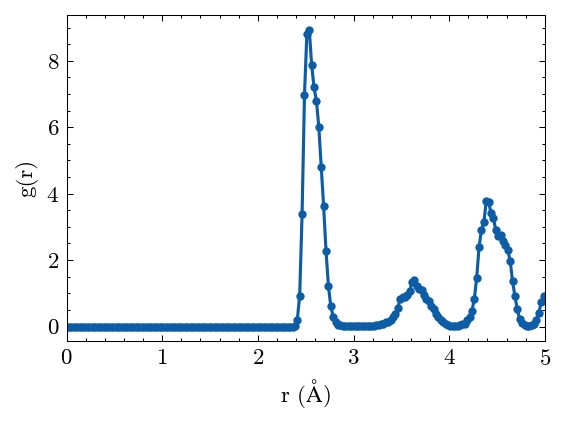

In [21]:
fig, ax = system.PairDistribution.plot()

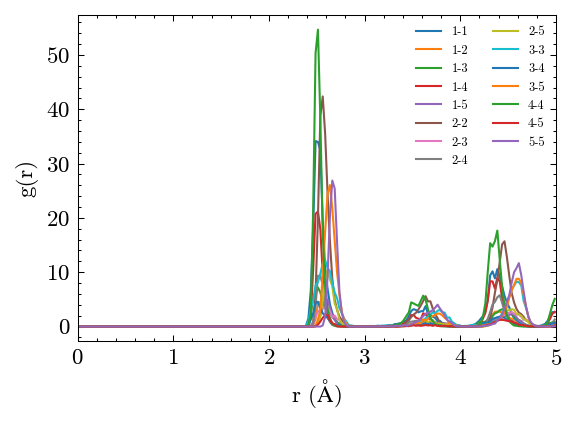

In [22]:
fig, ax = system.PairDistribution.plot_partial()

### 计算WCP参数

In [23]:
system.cal_warren_cowley_parameter()

In [24]:
system.WarrenCowleyParameter.WCP

array([[-1.39078011,  0.63941399,  0.39281243, -0.30495827,  0.66253483],
       [ 0.63941399, -1.93830149,  0.5804239 ,  0.51488099,  0.20334538],
       [ 0.39281243,  0.5804239 , -0.56415998,  0.6326128 , -1.04050757],
       [-0.30495827,  0.51488099,  0.6326128 , -1.69477812,  0.85080841],
       [ 0.66253483,  0.20334538, -1.04050757,  0.85080841, -0.67471711]])

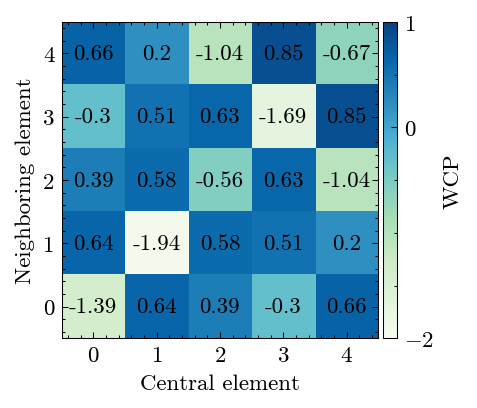

In [25]:
fig, ax = system.WarrenCowleyParameter.plot()

### PTM结构分析

In [26]:
system.cal_polyhedral_template_matching()

### 计算中心对称参数

In [27]:
system.cal_centro_symmetry_parameter()

### 计算构型熵

In [28]:
system.cal_atomic_entropy(rc=3.6*1.4, compute_average=True, average_rc=3.6*0.9)

### 计算Voronoi体积

In [29]:
system.cal_voronoi_volume()

### 查看计算结果

In [30]:
system.data.head()

id,type,x,y,z,structure_types,csp,atomic_entropy,ave_atomic_entropy,voronoi_volume,voronoi_number,cavity_radius
i64,i64,f64,f64,f64,i32,f64,f64,f64,f64,i32,f64
1,2,0.006118,-0.310917,-0.345241,1,0.100697,-5.997978,-6.469179,12.68101,15,3.675684
2,4,1.9019,-0.292456,1.48488,1,0.139544,-6.640982,-6.677862,12.012947,14,3.581766
3,3,-0.015641,1.58432,1.43129,1,0.094929,-6.821837,-6.666713,12.197214,12,3.674408
4,5,1.86237,1.51117,-0.372278,1,0.072999,-6.95832,-6.940526,12.900968,15,3.713117
5,5,3.79257,-0.331891,-0.37583,1,0.046358,-6.679066,-6.846047,12.400861,14,3.645415


### 可视化结果

In [31]:
system.display()

Output()

这里默认使用structure type对原子上色，也可以使用任意其他属性，比如原子type，原子体积等

In [32]:
system.atoms_colored_by('type')

In [33]:
system.atoms_colored_by('voronoi_volume')

### 保存结果到本地

- 保存粒子属性可以使用dump或者xyz格式

In [34]:
system.write_dump()

In [35]:
system.write_xyz()

### 判断FCC晶体是solid还是liquid

- 这里使用一个固液共存的dump文件为例子，元素为钼 Molybdenum 元素，熔点约2896 K
- 其原理是基于Steinhardt Bond order

In [36]:
system = mp.System('frame/solidliquid.dump')

In [37]:
system.cal_steinhardt_bond_orientation(solidliquid=True)

### 计算原子平均温度

In [38]:
system.cal_atomic_temperature(elemental_list=['Mo'])

In [39]:
print(f"Average temperature is {system.data['atomic_temp'].mean()} K")

Average temperature is 2672.4013143958755 K


In [40]:
system.data.head()

id,type,mass,x,y,z,vx,vy,vz,ql6,solidliquid,atomic_temp
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64
7913,1,95.94,2.64108,3.2152,1.74197,2.90096,1.72875,-1.77975,0.338703,0,2234.470269
4098,1,95.94,-0.091857,0.4658,0.936675,-0.166803,0.959803,3.70312,0.503473,0,2610.957915
4414,1,95.94,51.3076,2.93742,2.12484,4.50605,-1.06924,-1.41931,0.411614,0,2192.532239
4,1,95.94,3.57773,-0.024408,2.31072,-6.04709,5.23451,9.18538,0.304366,0,2351.722535
37,1,95.94,45.219,19.5654,-0.241386,-5.20306,3.79694,-2.15249,0.567507,0,2911.774301


In [41]:
system.atoms_colored_by('atomic_temp')

Output()

In [42]:
system.atoms_colored_by('solidliquid')

In [43]:
system.write_dump()

### 筛选原子可视化

In [44]:
solid = system.select(system.data.filter(pl.col('solidliquid')==1))

In [45]:
solid.display()

Output()

### 识别FCC基体中的ISF, ESF, TW, HCP

- 这里使用一个包含多种缺陷的dump文件

In [46]:
system = mp.System('frame/ISF.dump')

In [47]:
system.cal_identify_SFs_TBs()

In [48]:
system.display()

Output()

In [49]:
system.atoms_colored_by('fault_types')

In [50]:
system.write_dump()

### 斜盒子体系

- 大多数分析方式对斜盒子体系依然适用
- 这里读取一个HCP的Ti体系

In [51]:
Ti = mp.System('./frame/Ti.data')

In [52]:
Ti

Filename: ./frame/Ti.data
Atom Number: 2
Simulation Box:
[[ 2.93573192  0.          0.        ]
 [-1.46786596  2.54241842  0.        ]
 [ 0.          0.          4.64085615]
 [ 0.          0.          0.        ]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (2, 5)
┌─────┬──────┬────────────┬──────────┬──────────┐
│ id  ┆ type ┆ x          ┆ y        ┆ z        │
│ --- ┆ ---  ┆ ---        ┆ ---      ┆ ---      │
│ i64 ┆ i64  ┆ f64        ┆ f64      ┆ f64      │
╞═════╪══════╪════════════╪══════════╪══════════╡
│ 1   ┆ 1    ┆ -1.4679e-8 ┆ 1.694946 ┆ 1.160214 │
│ 2   ┆ 1    ┆ 1.467866   ┆ 0.847473 ┆ 3.480642 │
└─────┴──────┴────────────┴──────────┴──────────┘

In [53]:
Ti.cal_common_neighbor_analysis(rc=2.9357*1.207)

In [54]:
Ti.cal_centro_symmetry_parameter()

In [55]:
Ti.data

id,type,x,y,z,cna,csp
i64,i64,f64,f64,f64,i32,f64
1,1,-1.4679e-8,1.694946,1.160214,2,8.618522
2,1,1.467866,0.847473,3.480642,2,8.618522


In [56]:
Ti.display()

Output()

In [57]:
Ti.write_dump()

### 扩展体系并可视化

In [58]:
Ti.replicate(5, 5, 5)

In [59]:
Ti.atoms_colored_by('csp')

Output()

### 建立初始模型

1. mdapy可以建立一些简单的模型，比如FCC, BCC, HCP, Graphene，对于FCC和BCC还支持不同晶相
2. mdapy可以建立多晶，以及带石墨烯晶界的多晶
3. 用户可以手动提供元胞信息，然后适用mdapy扩胞，再进行筛选，比如建立任意类型的纳米颗粒等

In [60]:
fcc = mp.LatticeMaker(3.615, 'FCC', 10, 10, 10)
fcc.compute()

In [61]:
fcc.box

array([[36.15,  0.  ,  0.  ],
       [ 0.  , 36.15,  0.  ],
       [ 0.  ,  0.  , 36.15],
       [ 0.  ,  0.  ,  0.  ]])

In [62]:
fcc.pos

array([[ 0.    ,  0.    ,  0.    ],
       [ 1.8075,  1.8075,  0.    ],
       [ 1.8075,  0.    ,  1.8075],
       ...,
       [34.3425, 34.3425, 32.535 ],
       [34.3425, 32.535 , 34.3425],
       [32.535 , 34.3425, 34.3425]])

保存为data/dump文件

In [63]:
fcc.write_data(output_name='./frame/fcc.data')

我们来可视化一下结果，首先需要使用position和box来实例化一个System类

In [64]:
system = mp.System(pos=fcc.pos, box=fcc.box)

In [65]:
system

Filename: None
Atom Number: 4000
Simulation Box:
[[36.15  0.    0.  ]
 [ 0.   36.15  0.  ]
 [ 0.    0.   36.15]
 [ 0.    0.    0.  ]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (4_000, 5)
┌──────┬──────┬─────────┬─────────┬─────────┐
│ id   ┆ type ┆ x       ┆ y       ┆ z       │
│ ---  ┆ ---  ┆ ---     ┆ ---     ┆ ---     │
│ i32  ┆ i32  ┆ f64     ┆ f64     ┆ f64     │
╞══════╪══════╪═════════╪═════════╪═════════╡
│ 1    ┆ 1    ┆ 0.0     ┆ 0.0     ┆ 0.0     │
│ 2    ┆ 1    ┆ 1.8075  ┆ 1.8075  ┆ 0.0     │
│ 3    ┆ 1    ┆ 1.8075  ┆ 0.0     ┆ 1.8075  │
│ 4    ┆ 1    ┆ 0.0     ┆ 1.8075  ┆ 1.8075  │
│ …    ┆ …    ┆ …       ┆ …       ┆ …       │
│ 3997 ┆ 1    ┆ 32.535  ┆ 32.535  ┆ 32.535  │
│ 3998 ┆ 1    ┆ 34.3425 ┆ 34.3425 ┆ 32.535  │
│ 3999 ┆ 1    ┆ 34.3425 ┆ 32.535  ┆ 34.3425 │
│ 4000 ┆ 1    ┆ 32.535  ┆ 34.3425 ┆ 34.3425 │
└──────┴──────┴─────────┴─────────┴─────────┘

In [66]:
system.display()

Output()

对于FCC和BCC晶体可以指定初始晶向

In [67]:
fcc_111 = mp.LatticeMaker(3.615, 'FCC', 10, 10, 10, crystalline_orientation=np.array([[1,1,1], [1,-1,0], [1,1,-2]]))
fcc_111.compute()

In [68]:
fcc_111.write_dump(output_name='./frame/fcc_111.dump')

In [69]:
system = mp.System(pos=fcc_111.pos, box=fcc_111.box)

In [70]:
system.display()

Output()

mdapy处理几百万原子体系也很轻松，这里我们简单进行扩胞，生成一个400w原子体系进行测试

In [71]:
%%time
repli = mp.Replicate(fcc.pos, fcc.box, 10, 10, 10)
repli.compute()

CPU times: total: 15.6 ms
Wall time: 18.1 ms


In [72]:
repli.N

4000000

建立$rc=0.5nm$的邻域

In [73]:
%%time
neigh = mp.Neighbor(repli.pos, repli.box, 5., max_neigh=50)
neigh.compute()

CPU times: total: 7.27 s
Wall time: 758 ms


手动排序获取12个最近邻原子

In [74]:
%%time
neigh.sort_verlet_by_distance(12)

CPU times: total: 3.23 s
Wall time: 142 ms


In [75]:
neigh.verlet_list[0][:12]

array([      3,       2,       1, 3603602, 3603601,  360363,  360361,
         36039,   36038, 3639638,  396399, 3963961])

In [76]:
neigh.distance_list[0][:12]

array([2.55619101, 2.55619101, 2.55619101, 2.55619101, 2.55619101,
       2.55619101, 2.55619101, 2.55619101, 2.55619101, 2.55619101,
       2.55619101, 2.55619101])

使用kdtree来搜索12个最近邻原子

In [77]:
%%time
kdt = mp.NearestNeighbor(repli.pos, repli.box)
distance_list, verlet_list = kdt.query_nearest_neighbors(12)

CPU times: total: 17.6 s
Wall time: 1.82 s


In [78]:
verlet_list[0]

array([      2,       1,       3,   36039,   36038,  360361,  360363,
       3603602, 3603601,  396399, 3639638, 3963961], dtype=int64)

In [79]:
distance_list[0]

array([2.55619101, 2.55619101, 2.55619101, 2.55619101, 2.55619101,
       2.55619101, 2.55619101, 2.55619101, 2.55619101, 2.55619101,
       2.55619101, 2.55619101])

### 建立纳米晶

In [80]:
box = np.array([[200, 0, 0],
               [0, 200, 0],
               [0, 0, 200],
               [0, 0, 0.]])

In [81]:
poly = mp.CreatePolycrystalline(box, 20, 3.615, 'FCC', output_name='./frame/poly.dump', metal_overlap_dis=2.)
poly.compute()

Generating voronoi polygon...
Total grain number: 20
Generating grain 0..., volume is 175172.24021499304
Generating grain 1..., volume is 127414.73687883472
Generating grain 2..., volume is 659320.617142604
Generating grain 3..., volume is 569862.2242555253
Generating grain 4..., volume is 261708.57106941778
Generating grain 5..., volume is 360447.1638202893
Generating grain 6..., volume is 428283.20413467597
Generating grain 7..., volume is 220209.36062228394
Generating grain 8..., volume is 397416.3963106506
Generating grain 9..., volume is 360074.3795465595
Generating grain 10..., volume is 396925.96110056294
Generating grain 11..., volume is 182940.58149141038
Generating grain 12..., volume is 646427.8485708132
Generating grain 13..., volume is 532825.7961426476
Generating grain 14..., volume is 571844.3802420024
Generating grain 15..., volume is 342653.1071600422
Generating grain 16..., volume is 555731.7519084995
Generating grain 17..., volume is 433182.8864276381
Generating grai

使用DataFrame来实例化System

In [82]:
system = mp.System(data=poly.data, box=box)

In [83]:
system

Filename: None
Atom Number: 653965
Simulation Box:
[[200.   0.   0.]
 [  0. 200.   0.]
 [  0.   0. 200.]
 [  0.   0.   0.]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (653_965, 6)
┌────────┬──────┬───────────┬───────────┬────────────┬─────────┐
│ id     ┆ type ┆ x         ┆ y         ┆ z          ┆ grainid │
│ ---    ┆ ---  ┆ ---       ┆ ---       ┆ ---        ┆ ---     │
│ i32    ┆ i32  ┆ f32       ┆ f32       ┆ f32        ┆ i32     │
╞════════╪══════╪═══════════╪═══════════╪════════════╪═════════╡
│ 1      ┆ 1    ┆ 27.951    ┆ 17.377977 ┆ 74.145309  ┆ 1       │
│ 2      ┆ 1    ┆ 28.785088 ┆ 15.440113 ┆ 72.702019  ┆ 1       │
│ 3      ┆ 1    ┆ 27.815456 ┆ 13.773141 ┆ 74.379852  ┆ 1       │
│ 4      ┆ 1    ┆ 29.483633 ┆ 9.897412  ┆ 71.493271  ┆ 1       │
│ …      ┆ …    ┆ …         ┆ …         ┆ …          ┆ …       │
│ 653962 ┆ 1    ┆ 82.708847 ┆ 13.184875 ┆ 177.087479 ┆ 20      │
│ 653963 ┆ 1    ┆ 83.478714 ┆ 12.523629 ┆ 179.433578 ┆ 20      │
│ 653964 ┆ 1    ┆ 83.9

In [84]:
system.atoms_colored_by('grainid')

Output()

### EAM势函数分析

#### 生成一个Al的势函数

- mdapy可以基于文献生成一元或多元的eam.alloy势函数，可用于LAMMPS计算
- 可选元素列表 ["Cu","Ag","Au","Ni","Pd","Pt","Al","Pb","Fe","Mo","Ta","W","Mg","Co","Ti","Zr"]

In [85]:
mp.EAMGenerate(['Al'], output_name='./frame/Al.eam.alloy');

#### 读取刚才生成的势函数

In [86]:
potential = mp.EAM('./frame/Al.eam.alloy')

#### 查看势函数的相关信息

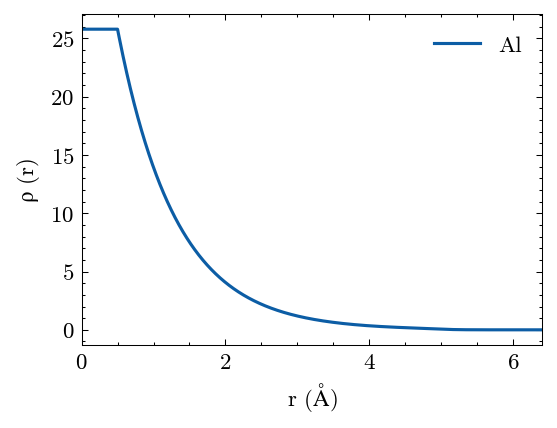

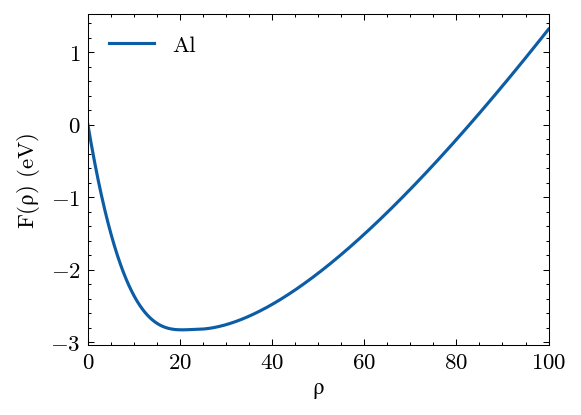

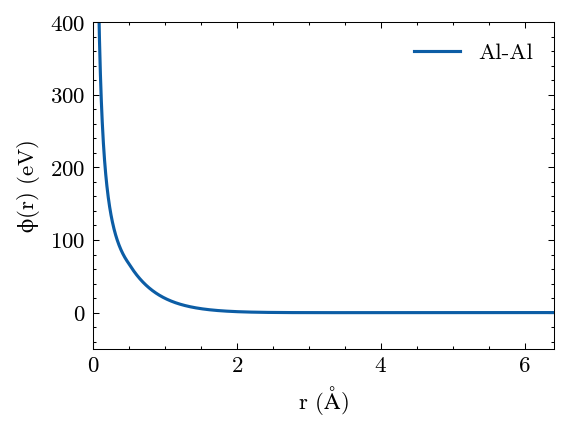

In [87]:
potential.plot()

#### 使用势函数计算Al的EOS曲线

In [88]:
energy = []
lattice_constant = 4.05
fcc = mp.LatticeMaker(lattice_constant, 'FCC', 1, 1, 1)
fcc.compute()
for scale in tqdm(np.arange(0.95, 1.06, 0.01)):
    Cal = mp.Calculator(potential, fcc.pos * scale, [1, 1, 1], fcc.box * scale, ['Al'], np.ones(fcc.N, int))
    Cal.compute()
    energy.append([lattice_constant*scale, Cal.energy.mean()])
energy = np.array(energy)

100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


Text(0, 0.5, 'PE (eV/atom)')

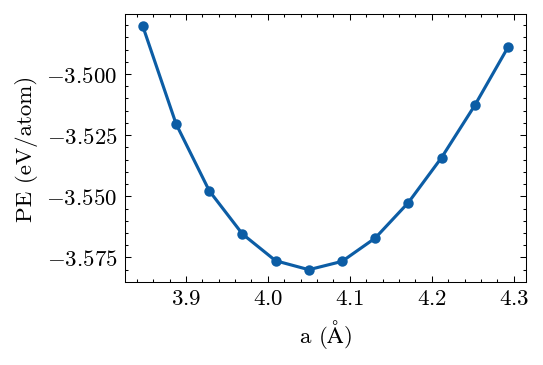

In [89]:
fig, ax = mp.set_figure(figsize=(8, 6), use_pltset=True)
plt.plot(energy[:, 0], energy[:, 1], 'o-')
plt.xlabel('a ($\mathregular{\AA}$)')
plt.ylabel('PE (eV/atom)')

### 分析化学产物

mdapy目前判断两个原子的连接性的是比较经验的，当两个原子的距离小于其范德华半径之和的0.6倍，
则认为两个原子成键，然后基于成键关系来进行聚合，得出产物的种类和数目。

- 这里读取一个AP+Al的文件作为例子
- 其中的元素顺序为["H", "C", "N", "O", "F", "Al", "Cl"]

In [90]:
system = mp.System('frame/ap@al.dump')

In [91]:
system.display()

Output()

我们可以首先看一下这里面包含的最多的产物是那些，这里查看了数目前20的产物

In [92]:
species = system.cal_species_number(element_list=["H", "C", "N", "O", "F", "Al", "Cl"], check_most=20)

In [93]:
species

{'HHO': 3303,
 'Cl': 1434,
 'NN': 594,
 'ClH': 374,
 'COO': 356,
 'HHHO': 327,
 'NO': 296,
 'OO': 200,
 'HHHHOO': 190,
 'ClHHO': 145,
 'HO': 81,
 'HHHHHOO': 75,
 'ClHHHO': 73,
 'CCCHHHHH': 62,
 'CCCCHHHHHH': 60,
 'CCCHHHHHH': 58,
 'CCCCHHHHHHH': 56,
 'CCHHHH': 52,
 'HHNNO': 50,
 'HHHOO': 44}

我们可以看到，最多的是H2O, Cl原子，N2, HCl, CO2 大概确定以后，我们可以实际输入我们关心的产物

In [94]:
species = system.cal_species_number(element_list=["H", "C", "N", "O", "F", "Al", "Cl"], 
                                    search_species=['H2O', 'Cl', 'N2', 'CO2', 'HCl', 'X'])

这里'X'元素是一个虚构的元素，也就是如果你想要的产物没有，则会返回数目为0

In [95]:
species

{'H2O': 3303, 'Cl': 1434, 'N2': 594, 'CO2': 356, 'HCl': 374, 'X': 0}

### 区域划分统计

mdapy可以对体系进行1维，2维，3维网格划分，并对里面的物理量进行平均，求和，最大值，最小值计算等操作

- 这里我们以温度为例

首先计算原子的平均温度

In [96]:
system.cal_atomic_temperature(elemental_list=["H", "C", "N", "O", "F", "Al", "Cl"])

In [97]:
print(f"The mean temperature is {system.data['atomic_temp'].mean()} K.")

The mean temperature is 2412.0673636586694 K.


In [98]:
system.atoms_colored_by('atomic_temp', vmin=1000, vmax=3000)

对温度在xy平面进行二维划分并求平均

In [99]:
system.spatial_binning('xy', 'atomic_temp')

In [100]:
T = system.Binning.res[:, :, -1]
x, y = system.Binning.coor['x'], system.Binning.coor['y']
X, Y = np.meshgrid(x, y, indexing='ij')

Text(0, 0.5, 'y ($\\mathregular{\\AA}$)')

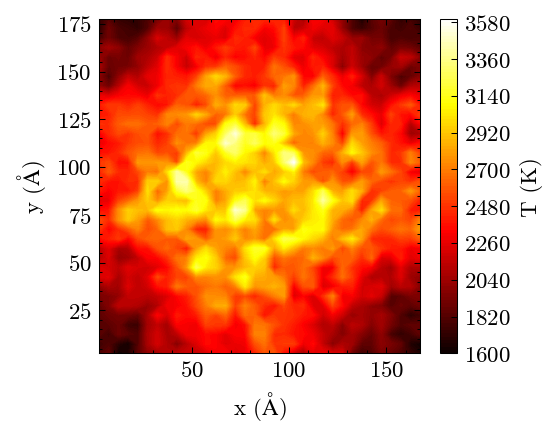

In [101]:
fig, ax = mp.set_figure(figsize=(8, 7.5), use_pltset=True)
h = ax.contourf(X, Y, T, cmap='hot', levels=100)
bar = plt.colorbar(h, ax=ax)
bar.set_label('T (K)')
ax.set_xlabel('x ($\mathregular{\AA}$)')
ax.set_ylabel('y ($\mathregular{\AA}$)')

### 处理轨迹

如前文所说，mdapy并不是为了处理轨迹类文件的，mdapy提供的分析功能中只有计算MSD和Lindemann系数需要考虑不同frame间的关系。
对于计算RDF这种，实际上可以通过一个简单的for-loop来进行平均，对于轨迹文件处理有几个注意事项。

1. mdapy不能读取一个文件中包含多个Frame的格式，用户需要手动对轨迹文件进行切割，始终牢记mdapy是为了处理单frame设计的
2. mdapy会把轨迹中的所有frame都读取到内存中来，所以用户要谨慎思考自己的体系是否需要那么多frame
3. 为了计算MSD和Lindemann系数，mdapy会自动将轨迹中的坐标根据边界条件展开且会对原子序号排序，只有计算这两个参数，用户才应该使用MultiSystem,其余情况都应该使用System


- 这里我们读取rdf.0.dump到rdf.4.dump总共5个frames来进行计算

In [102]:
MS = mp.MultiSystem([f'traj/rdf.{i}.dump' for i in range(5)])

Reading traj/rdf.4.dump: 100%|██████████| 5/5 [00:00<00:00, 246.63it/s]


In [103]:
MS[0]

Filename: traj/rdf.0.dump
Atom Number: 15625
Simulation Box:
[[ 27.4946022   0.          0.       ]
 [  0.         27.4946022   0.       ]
 [  0.          0.         27.4946022]
 [-13.7473011 -13.7473011 -13.7473011]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (15_625, 5)
┌───────┬──────┬───────────┬────────────┬────────────┐
│ id    ┆ type ┆ x         ┆ y          ┆ z          │
│ ---   ┆ ---  ┆ ---       ┆ ---        ┆ ---        │
│ i64   ┆ i64  ┆ f64       ┆ f64        ┆ f64        │
╞═══════╪══════╪═══════════╪════════════╪════════════╡
│ 1     ┆ 0    ┆ 10.01553  ┆ -4.348063  ┆ -6.279958  │
│ 2     ┆ 0    ┆ -5.159263 ┆ -6.642017  ┆ 1.14219    │
│ 3     ┆ 0    ┆ 0.46146   ┆ -6.818775  ┆ -12.233191 │
│ 4     ┆ 0    ┆ 6.030577  ┆ 9.578183   ┆ 4.405061   │
│ …     ┆ …    ┆ …         ┆ …          ┆ …          │
│ 15622 ┆ 0    ┆ 5.137051  ┆ -12.663301 ┆ 10.457383  │
│ 15623 ┆ 0    ┆ 8.717108  ┆ 10.436789  ┆ 9.101261   │
│ 15624 ┆ 0    ┆ -2.603855 ┆ 6.279372   ┆ 5.93687

### 计算MSD

In [104]:
MS.cal_mean_squared_displacement()

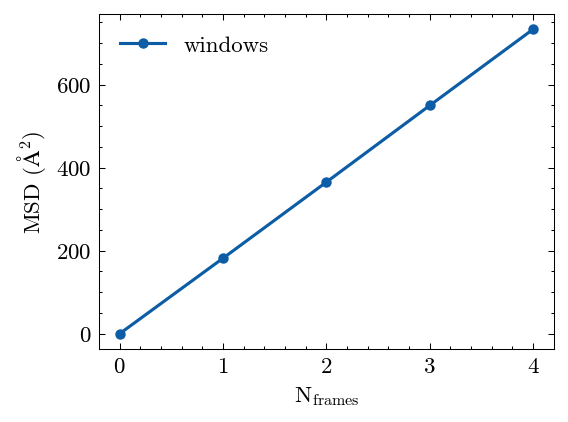

In [105]:
fig, ax = MS.MSD.plot()

### 计算Lindemann index

In [106]:
MS.cal_lindemann_parameter()

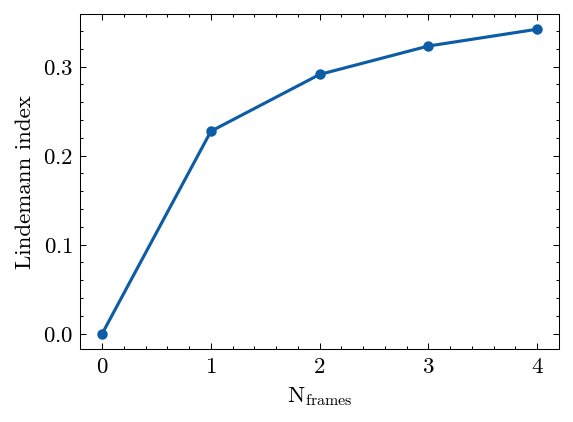

In [107]:
fig, ax = MS.Lindemann.plot()

mdapy会把每个原子在MSD和lindemann系数上的贡献保存下来

In [108]:
MS[0]

Filename: traj/rdf.0.dump
Atom Number: 15625
Simulation Box:
[[ 27.4946022   0.          0.       ]
 [  0.         27.4946022   0.       ]
 [  0.          0.         27.4946022]
 [-13.7473011 -13.7473011 -13.7473011]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
shape: (15_625, 7)
┌───────┬──────┬───────────┬────────────┬────────────┬─────────────┬───────────┐
│ id    ┆ type ┆ x         ┆ y          ┆ z          ┆ msd         ┆ lindemann │
│ ---   ┆ ---  ┆ ---       ┆ ---        ┆ ---        ┆ ---         ┆ ---       │
│ i64   ┆ i64  ┆ f64       ┆ f64        ┆ f64        ┆ f64         ┆ f64       │
╞═══════╪══════╪═══════════╪════════════╪════════════╪═════════════╪═══════════╡
│ 1     ┆ 0    ┆ 10.01553  ┆ -4.348063  ┆ -6.279958  ┆ 0.0         ┆ 0.0       │
│ 2     ┆ 0    ┆ -5.159263 ┆ -6.642017  ┆ 1.14219    ┆ -1.1369e-13 ┆ 0.0       │
│ 3     ┆ 0    ┆ 0.46146   ┆ -6.818775  ┆ -12.233191 ┆ 5.6843e-14  ┆ 0.0       │
│ 4     ┆ 0    ┆ 6.030577  ┆ 9.578183   ┆ 4.405061   ┆ 0.0   

用户可以把结果保存到一系列dump文件中

In [109]:
MS.write_dumps()

Saving traj/rdf.4.dump: 100%|██████████| 5/5 [00:00<00:00, 306.14it/s]


# 实战案例：计算层错能

这里我们以Al为例，计算他在<112>方向滑移的层错能。

## 建立一个晶向为x[11-2], y[1-10], z[111]的构型

In [110]:
lattice_constant = 4.05
lattice_type = 'FCC'
fcc = mp.LatticeMaker(lattice_constant, 
                      lattice_type, 
                      10, 15, 10, 
                      crystalline_orientation=
                      np.array([[1, 1, -2], 
                                [1, -1, 0], 
                                [1, 1, 1]]))
fcc.compute()
system = mp.System(pos=fcc.pos, box=fcc.box)

In [111]:
system.display()

Output()

## 将z方向改为自由边界

In [112]:
system.boundary[-1] = 0

## 计算初始的势能

In [113]:
system.cal_energy_force('frame/Al_DFT.eam.alloy', ['Al'], max_neigh=150)
pe0 = system.data['pe'].sum()

## 定义每一次移动的间隔距离

In [114]:
move = (lattice_constant/6**0.5+0.2)/50
factor = system.box[0,0] * system.box[1,1]/16021.766200000002 # 转换系数

## 开始循环计算

In [115]:
sfe = [0.]
for i in tqdm(range(1, 51)):
    newdata = system.data.with_columns(
        pl.when(pl.col('z')>35).
        then(pl.col('x')+move).
        otherwise(pl.col('x')).
        alias('x'))
    system.update_data(newdata, update_pos=True) # 移动上半部分
    system.wrap_pos() # 周期性折叠
    system.if_neigh = False # 确保重新建立邻域
    system.cal_energy_force('frame/Al_DFT.eam.alloy', ['Al'], max_neigh=150)
    sfe.append((system.data['pe'].sum()-pe0)/factor)

100%|██████████| 50/50 [00:03<00:00, 14.57it/s]


## 绘制结果

Text(0.97, 25, 'ISF')

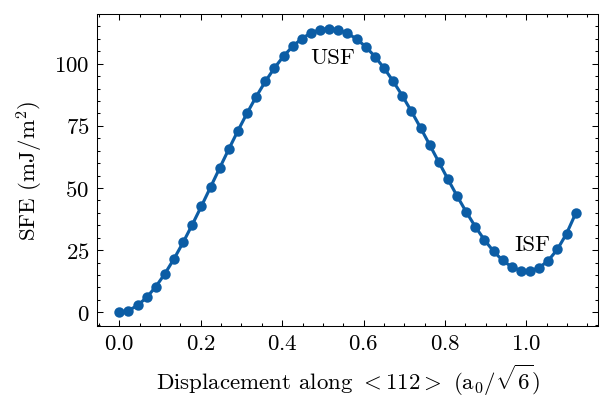

In [116]:
fig, ax = mp.set_figure(figsize=(10, 7), use_pltset=True)

plt.plot(np.arange(51)*move/(lattice_constant/6**0.5), sfe, 'o-')
plt.xlabel("Displacement along $<112>$ " + "$\mathregular{(a_0/\sqrt{6})}$")
plt.ylabel("SFE ($\mathregular{mJ/{m^2}}$)")
plt.text(0.47, 100, 'USF')
plt.text(0.97, 25, 'ISF')

# 发展mdapy

mdapy目前还是一个在快速迭代发展的程序，但是由于我个人时间有限，难免会存在一些bug，比如文档错误，代码在有些情况会出错等。
大家可以通过在github主页上面提交issue进行反馈。我有时间的话会尽快修复。如果有一些功能在mdapy中没有实现，但是又确实很常用，
也可以在issue里面反馈。

> 最后，如果你喜欢mdapy，请给它Star。如果你在文章中使用了mdapy，请引用它。

<img src="image/activities.jpg" alt="activities.jpg" border="0" width="800"/>